In [2]:
##IMPORTS
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import shapely
import skimage
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from numba import njit

In [3]:
class Preprocessing:
    def __init__(self, raster_path, vector_path, crs="EPSG:32651", pneo=False):
        self.raster_path = raster_path
        self.vector_path = vector_path
        self.crs = crs
        self.pneo = pneo

        self._rep_data = None
        self._rep_trans = None
        self._rep_crs = None

        self._clipped_data = None
        self._clipped_transform = None

    def reproject(self, target_crs="EPSG:32651", resampling=rasterio.enums.Resampling.nearest):
        if self.pneo:
            with rasterio.open(self.raster_path) as src:
                with rasterio.vrt.WarpedVRT(src, crs=target_crs, resampling=resampling) as vrt:
                    self._rep_data = vrt.read([1,2,3])
                    self._rep_trans = vrt.transform
                    self._rep_crs = vrt.crs
        else:
            with rasterio.open(self.raster_path) as src:
                with rasterio.vrt.WarpedVRT(src, crs=target_crs, resampling=rasterio.enums.Resampling.nearest) as vrt:
                    self._rep_data = vrt.read()
                    self._rep_trans = vrt.transform
                    self._rep_crs = vrt.crs

        return self._rep_data, self._rep_trans, self._rep_crs

    def clipraster(self, raster_data=None, transform=None, buffer_dist = 15, bbox = False):
        if self.vector_path is None:
            self._clipped_data = self._rep_data
            self._clipped_transform = self._rep_trans

            return self._clipped_data, self._clipped_transform
        
        if raster_data is None:
            if self._rep_trans is None:
                raise ValueError("Reproject has not been performed. Call reproject() first.")
            else:
                raster_data = self._rep_data

        centerline = gpd.read_file(self.vector_path).to_crs(self.crs)

        buffered_lines = []
        for geometry in centerline.geometry:
            if isinstance(geometry, shapely.geometry.MultiLineString):
                for line in geometry.geoms:
                    buffered_lines.append(line.buffer(buffer_dist))
            elif isinstance(geometry, shapely.geometry.LineString):
                buffered_lines.append(geometry.buffer(buffer_dist))
            else:
                raise ValueError("Centerline not properly formatted") 

        buffered_lines_gdf = gpd.GeoDataFrame({"geometry": buffered_lines}, crs=self.crs)
    
        if bbox:
            bounding_box = buffered_lines_gdf.total_bounds
            bbox_polygon = shapely.geometry.box(*bounding_box)
            clipping_gdf = gpd.GeoDataFrame({"geometry": [bbox_polygon]}, crs=self.crs)
        else:
            clipping_gdf = buffered_lines_gdf

        clipping_geom = [geom.__geo_interface__ for geom in clipping_gdf.geometry]

        if transform is None:
            if self._rep_trans is None:
                raise ValueError("Reproject has not been performed. Call reproject() first.")
            else:
                transform = self._rep_trans #if transform not specified, use reprojected transform

        # Perform masking
        count = raster_data.shape[0] if len(raster_data.shape) == 3 else 1
        with rasterio.MemoryFile() as memfile:
            with memfile.open(
                driver="GTiff",
                height=raster_data.shape[-2],
                width=raster_data.shape[-1],
                count=count,
                dtype=raster_data.dtype,
                transform=transform,
                crs=self.crs,
            ) as dataset:
                if count == 1:
                    dataset.write(raster_data, 1)
                else:
                    for i in range(count):
                        dataset.write(raster_data[i], i + 1)

                # Debug masking
                try:
                    self._clipped_data, self._clipped_transform = mask(dataset, clipping_geom, crop=True)
                except ValueError as e:
                    print("Error during masking:", str(e))
                    raise

        return self._clipped_data, self._clipped_transform
    
    def display(self):
        if self._clipped_data is None:
            raise ValueError("Clipped data has not been generated. Call 'clipraster()' first.")
        else:
            data = self._clipped_data
            
        data = np.moveaxis(data, 0, -1)
        
        plt.imshow(data)
        plt.title(f"Clipped Image")
        plt.axis('off')
        plt.show()

In [4]:
class Filters:
    def __init__(self, raster_data, pneo=False):
        self.pneo = pneo
        self.raster_data = raster_data
        self._enhanced_warmth = None
        self._enhanced_stretched = None

    # @njit    
    def enhance_image_warmth(self):
        '''Enhances the warmth of an image's RGB bands'''

        if self.raster_data.dtype == np.uint16:
            raster_data = (self.raster_data / 65535.0 * 255).astype(np.uint8)
        
        else:
            raster_data = self.raster_data
            
        raster_data = np.moveaxis(raster_data, 0, -1) 
        enhanced_data = raster_data.copy()

        # Create masks for different conditions
        r = enhanced_data[:, :, 0]
        g = enhanced_data[:, :, 1]
        b = enhanced_data[:, :, 2]

        # Apply transformations for red channel
        r_mask_1 = (r < 30)
        r_mask_2 = (r >= 30) & (r < 100)
        r_mask_3 = (r >= 100) & (r < 175)
        r_mask_4 = (r >= 175) & (r < 255)

        r[r_mask_1] += 35
        r[r_mask_2] += 20
        r[r_mask_3] += 15
        r[r_mask_4] += 7

        # Apply transformations for green channel
        g_mask_1 = (g < 30)
        g_mask_2 = (g >= 30) & (g < 50)
        g_mask_3 = (g >= 50) & (g < 80)
        g_mask_4 = (g >= 80) & (g < 102)

        g[g_mask_1] += 30
        g[g_mask_2] += 20
        g[g_mask_3] += 15
        g[g_mask_4] = 90

        # Apply transformations for blue channel
        b_mask_1 = (b > 150)
        b_mask_2 = (b > 70) & (b <= 150)
        b_mask_3 = (b > 30) & (b <= 70)
        b_mask_4 = (b > 0) & (b <= 30)

        b[b_mask_1] -= 90
        b[b_mask_2] -= 40
        b[b_mask_3] -= 20
        b[b_mask_4] = 15

        # Update the enhanced_data array
        enhanced_data[:, :, 0] = r
        enhanced_data[:, :, 1] = g
        enhanced_data[:, :, 2] = b
        
        enhanced_data = (enhanced_data.astype(np.float32) / 255.0 * 65535).astype(np.uint16)
        enhanced_data = np.moveaxis(enhanced_data, -1, 0)
        self._enhanced_warmth = enhanced_data

        return self._enhanced_warmth
    
    def enhance_linear_stretch(self, lower_percent=98, upper_percent=100):
        """
        Apply linear stretching to enhance the image contrast.

        Parameters:
        - image: numpy array, the input raster image.
        - lower_percent: float, lower percentile to saturate.
        - upper_percent: float, upper percentile to saturate.

        Returns:
        - Stretched image as a numpy array.
        """
        if self.pneo:
            # lower, upper = 0, 100
            in_min = np.percentile(self.raster_data, lower_percent)
            in_max = np.percentile(self.raster_data, upper_percent)
            image = np.clip(self.raster_data, in_min, in_max)
            out_min, out_max = np.min(self.raster_data), np.max(self.raster_data)
            stretched_image = (image - in_min) / ((in_max - in_min) * (out_max - out_min))
            self._enhanced_stretched = stretched_image

        else:
            in_min = np.percentile(self.raster_data, lower_percent)
            in_max = np.percentile(self.raster_data, upper_percent)
            image = np.clip(self.raster_data, in_min, in_max)
            out_min, out_max = np.min(self.raster_data), np.max(self.raster_data)
            stretched_image = (image - in_min) / ((in_max - in_min) * (out_max - out_min))
            self._enhanced_stretched = stretched_image

        return self._enhanced_stretched

In [5]:
class Morph:
    def __init__(self, raster_data):
        self.raster_data = raster_data

        self._normalized = None
        self._edges = None
        self._thresholded = None
        self._merged = None
        self._morphed = None
        self._normalized_gray = None
    
    def normalize_band(self, band):
        return (band - band.min()) / (band.max() - band.min())

    # Normalize all bands
    def normalize_raster(self):
        self._normalized = (self.raster_data - self.raster_data.min()) / (self.raster_data.max() - self.raster_data.min())
        
        if self._normalized.shape[0] == 3:  # For RGB
            self.normalized_grayscale = skimage.color.rgb2gray(np.moveaxis(self._normalized, 0, -1))
            self._normalized_gray = self.normalized_grayscale

        elif self._normalized.shape[0] == 4: #for PNEO
            self.normalized_grayscale = skimage.color.rgb2gray(np.moveaxis(self._normalized, 0, -1))
            self._normalized_gray = self.normalized_grayscale
            
        else:
            self.normalized_grayscale = self._normalized[0]  #if single-band image
            self._normalized_gray = self.normalized_grayscale
            
    def detect_edge(self):
        self._edges = skimage.feature.canny(self.normalized_grayscale, sigma=1.4, low_threshold = 0.1, high_threshold = 0.5)
            
    def threshold_raster(self):
        otsu = skimage.filters.threshold_otsu(self.normalized_grayscale)
        self._thresholded = self.normalized_grayscale > otsu

    def merge(self):
        if self._edges is not None and self._thresholded is not None:
            self._merged = np.logical_and(self._edges, self._thresholded)
        else:
            raise ValueError("Edge detection or thresholding has not been performed yet.")

    def morphology(self, a=5, b=3):
        thresholded = self._thresholded.astype(np.uint8)

        kernel_a = np.ones((a, a), np.uint8)
        canny_dilated = cv2.dilate(self._edges.astype(np.uint8), kernel_a, iterations=3)

        kernel_b = np.ones((b,b), np.uint8)
        canny_eroded = cv2.erode(canny_dilated, kernel_b, iterations=7).astype(np.uint8)

        ##Merged_0: Merged (T+(T>D>E))
        self._morphed = np.logical_and(thresholded, canny_eroded) 

    def process(self):
        self.normalize_raster()
        self.detect_edge()
        self.threshold_raster()
        self.morphology()

        # return self._merged
        
    def display(self, data_type="morphed"):
        if data_type == "normalized":
            if self._normalized is None:
                raise ValueError("Normalized data has not been generated. Call `process()` first.")
            data = self._normalized
        elif data_type == "normalized_gray":
            if self._normalized_gray is None:
                 raise ValueError("Grayscale has not been performed. Call `process()` first.")
            data = self._normalized_gray
        elif data_type == "edges":
            if self._edges is None:
                raise ValueError("Edge detection has not been performed. Call `process()` first.")
            data = self._edges.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "thresholded":
            if self._thresholded is None:
                raise ValueError("Thresholding has not been performed. Call `process()` first.")
            data = self._thresholded.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "merged":
            if self._merged is None:
                raise ValueError("Merged result has not been created. Call `process()` first.")
            data = self._merged.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "morphed":
            if self._morphed is None:
                raise ValueError("Final result has not been created. Call `process()` first.")
            data = self._morphed.astype(np.uint8)  # Convert boolean to uint8
        else:
            raise ValueError(f"Invalid data_type: {data_type}. Choose from 'normalized', 'edges', 'thresholded', 'merged', 'morphed'.")
        
        data = data
        plt.imshow(data, cmap='gray')
        plt.title(f"{data_type}")
        plt.axis('off')
        plt.show()

    @property
    def normalized(self):
        if self._normalized is None:
            raise ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._normalized

    @property
    def edges(self):
        if self._edges is None:
            raise ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._edges

    @property
    def thresholded(self):
        if self._thresholded is None:
            raise ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._thresholded

    @property
    def merged(self):
        if self._merged is None:
            ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._merged

    @property  
    def output(self):
        if self._morphed is None:
            ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._morphed

    def export(self, output_path, data_type="merged", transform=None, crs=None):

        """
        Export the specified processed raster to a GeoTIFF file.
    
        Args:
            output_path (str): Path to save the GeoTIFF file.
            data_type (str): Type of data to export ('normalized', 'edges', 'thresholded', 'merged').
            transform (affine.Affine): Affine transform for the raster. Defaults to `None`.
            crs (dict or str): CRS of the raster. Defaults to `None`.
        """
        output_folder = os.path.dirname(output_path)
        if not os.path.exists(output_folder):       #create folder if it doesn't exist
            os.makedirs(output_folder)

        # Select the appropriate data based on `data_type`
        if data_type == "normalized":
            if self._normalized is None:
                raise ValueError("Normalized data has not been generated. Call `process()` first.")
            data = self._normalized
        elif data_type == "edges":
            if self._edges is None:
                raise ValueError("Edge detection has not been performed. Call `process()` first.")
            data = self._edges.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "thresholded":
            if self._thresholded is None:
                raise ValueError("Thresholding has not been performed. Call `process()` first.")
            data = self._thresholded.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "merged":
            if self._merged is None:
                raise ValueError("Merged result has not been created. Call `process()` first.")
            data = self._merged.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "morphed":
            if self._morphed is None:
                raise ValueError("Final result has not been created. Call `process()` first.")
            data = self._morphed.astype(np.uint8)  # Convert boolean to uint8
        else:
            raise ValueError(f"Invalid data_type: {data_type}. Choose from 'normalized', 'edges', 'thresholded', 'merged', 'morphed'.")
    
        # Ensure transform and CRS are provided
        if transform is None or crs is None:
            raise ValueError("Both `transform` and `crs` must be provided for export.")
    
        # Write the raster to a GeoTIFF file
        with rasterio.open(
            output_path,
            "w",
            driver="GTiff",
            height=data.shape[0],
            width=data.shape[1],
            count=1,
            dtype=data.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(data, 1)
            
        basename = os.path.basename(output_path)
        return print(f"Successfully saved {basename} to {output_path}")

In [6]:
class MeasureWidth:
    def __init__(self, raster_data, raster_transform, centerline_path, raster_crs="EPSG:32651"):
        self.raster_data = raster_data
        self.transform = raster_transform
        self.crs = raster_crs
        self.centerline = gpd.read_file(centerline_path)
        self.vectorized_roads = None
        self._transects = None
        self.clipped_transects = None
        
    def create_transects(self, transect_length=10, interval=10):
        """Create transects perpendicular to a centerline at regular intervals."""
        self.centerline = self.centerline.to_crs(self.crs)
        self.centerline = self.centerline.geometry[0]
        
        transects = []
        for i in range(0, int(self.centerline.length), interval):
            point = self.centerline.interpolate(i)
            next_point = self.centerline.interpolate(i + 1)

            # Convert tuples to numpy arrays and ensure they are 2D (x, y)
            point_coords = np.array(point.coords[0][:2])
            next_point_coords = np.array(next_point.coords[0][:2])

            normal = next_point_coords - point_coords
            normal = np.array([-normal[1], normal[0]])  # Rotate 90 degrees to get normal vector
            normal = normal / np.linalg.norm(normal) # Normalize the vector
            
            transect_start = point_coords + normal * -transect_length  # Extend 10 meters on one side
            transect_end = point_coords + normal * transect_length  # Extend 10 meters on the other side

            transects.append(shapely.geometry.LineString([transect_start, transect_end]))

        self._transects = gpd.GeoDataFrame(geometry=transects, crs=self.crs)
        return self._transects

    def vectorize_roads(self, smooth=True, tolerance=None, resolution=None):
        """Vectorize the road areas (where raster value is 1) and optionally smooth the edges."""
        # Mask out non-road areas
        road_mask = self.raster_data == 1
        if np.sum(road_mask) == 0:
            print("No roads found in the raster data.")
            return None  # No roads to vectorize

        # Vectorize the road mask using rasterio.features.shapes
        shapes_generator = rasterio.features.shapes(self.raster_data, mask=road_mask, transform=self.transform)
    
        # Create GeoDataFrame from vectorized shapes
        if tolerance is None:
            tolerance = 1.0

        geometries = []
        for geom, value in shapes_generator:
            if value == 1:  # Only keep the shapes with value 1 (road areas)
                geom_shape = shapely.geometry.shape(geom)
                # Apply smoothing if enabled
                if smooth:
                    geom_shape = geom_shape.buffer(tolerance, resolution=resolution).buffer(-tolerance, resolution=resolution).simplify(tolerance, preserve_topology=True)
                geometries.append(geom_shape)
        
        if len(geometries) == 0:
            print("No vectorized roads found.")
            return None  # No geometries were created
        
        # Create a GeoDataFrame to store the vectorized roads
        self.vectorized_roads = gpd.GeoDataFrame(geometry=geometries, crs=self.crs)
        return self.vectorized_roads

    def clip_transects(self):
        """Clip transects using the vectorized roads and save the result."""
        if self.vectorized_roads is None:
            raise ValueError("Roads not vectorized. Run vectorize_roads() first.")

        # Clip transects with the vectorized roads
        clipped = gpd.overlay(self._transects, self.vectorized_roads, how='intersection')

        self.clipped_transects = clipped

    def clip_transects(self):
        """Clip transects using the vectorized roads and save the result."""
        if self.vectorized_roads is None:
            raise ValueError("Roads not vectorized. Run vectorize_roads() first.")

        # Clip transects with the vectorized roads
        clipped = gpd.overlay(self._transects, self.vectorized_roads, how='intersection')
        
        self.clipped_transects = clipped
        self.clipped_transects['width'] = clipped.geometry.length

        return self.clipped_transects[['geometry', 'width']]
    
    def filter_transects(self):
        if self.clipped_transects is None:
            raise ValueError("Transects not measured. Run clip_transects() first.")
        
        if self.clipped_transects["width"].mean() < 4:
            self.clipped_transects = self.clipped_transects[(self.clipped_transects["width"] >= 3) & (self.clipped_transects["width"] <= 5)]
        else:                                                    
            self.clipped_transects = self.clipped_transects[(self.clipped_transects["width"] >= 4) & (self.clipped_transects["width"] <= 8)]

    def process(self, tolerance=None, resolution=None):
        self.create_transects()
        self.vectorize_roads(tolerance=tolerance, resolution=resolution)
        self.clip_transects()
        self.filter_transects()
        return self.clipped_transects[['geometry', 'width']]

    def export(self, output_path, gdf=None):
         # Ensure the output folder exists
        output_folder = os.path.dirname(output_path)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        if self.clipped_transects is None:
            raise ValueError("Transects not measured. Run process() first.")
        
        if gdf is None:
            gdf = self.clipped_transects

        gdf.to_file(output_path, crs=self.crs)

        return print(f"Road width exported successfully to {output_path}")
    
    @property
    def vectorized(self):
        if self.vectorized_roads is None:
            raise ValueError("Road not vectorized. Run process() first.")
        return self.vectorized_roads
    
    @property
    def transects(self):
        if self.clipped_transects is None:
            raise ValueError("Transects not measured. Run process() first.")
        
        return self.clipped_transects

In [7]:
def export(raster, transform, output_path, crs="EPSG: 32651"):
    # Ensure output folder exists
    output_folder = os.path.dirname(output_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with rasterio.open(
            output_path,
            "w",
            driver="GTiff",
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=raster.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(raster, 1)
            
    basename = os.path.basename(output_path)
    return print(f"Successfully saved {basename} to {output_path}")

In [8]:
def normalize(raster_data):
    #normalize PNEO data to [0, 1]
    normalized = (raster_data - raster_data.min()) / (raster_data.max() - raster_data.min())

    #create grays image for canny and otsu
    if normalized.shape[0] == 4:
        normalized_gray = skimage.color.rgb2gray(np.moveaxis(normalized, 0, -1))
    else:
        normalized_gray = normalized[0]

    return normalized, normalized_gray

def get_edges(raster_data, sigma, low, high): #raster_data = gray
    raster_edge = skimage.feature.canny(raster_data, sigma = sigma, low_threshold=low, high_threshold=high) #sigma = , low_threshold = , high_threshold = 

    return raster_edge

def get_threshold(raster_data):
    otsu = skimage.filters.threshold_otsu(raster_data)
    thresholded = raster_data > otsu
    return thresholded

def morphology(threshold, canny, a=5, b=3, iter=(3,3)):
        iter_dil, iter_ero = iter
        thresholded = threshold.astype(np.uint8)

        kernel_a = np.ones((a, a), np.uint8)
        canny_dilated = cv2.dilate(canny.astype(np.uint8), kernel_a, iterations=iter_dil)

        kernel_b = np.ones((b,b), np.uint8)
        canny_eroded = cv2.erode(canny_dilated, kernel_b, iterations=iter_ero).astype(np.uint8)

        ##Merged_0: Merged (T+(T>D>E))
        morphed = np.logical_and(thresholded, canny_eroded)
        
        return morphed

In [11]:
#preprocessing
raster_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_05315915405614\FMR 26\FMR26-PANSHARPENED.tif"
vector_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_05315915405614\FMR 26\FMR26_PNEO_CL.shp"

dirname = os.path.dirname(raster_path)
basename = os.path.basename(dirname)

preprocessor = Preprocessing(raster_path, vector_path, pneo=True)
preprocessor.reproject()
clipped_data, clipped_transform = preprocessor.clipraster() #bbox=False
print(f"Shape of clipped data: {clipped_data.shape}" )

# Filters: warmth and linear stretch
filter = Filters(clipped_data)
# warm_raster = filter.enhance_image_warmth()
stretch_raster = filter.enhance_linear_stretch()
print(f"Shape of clipped data: {stretch_raster.shape}" )
print("Applying filter completed.")

# #Apply erode
# morph_warm = Morph(warm_raster)
# morph_warm.process()

# morph_stretch = Morph(stretch_raster)
# morph_stretch.process()

# #merges the applied morphed warmth and stretch function
# merged_or = np.logical_or(morph_warm.output, morph_stretch.output)

# morph_warm.display(data_type="morphed")
# morph_stretch.display(data_type="morphed")

Shape of clipped data: (3, 3396, 9364)
Shape of clipped data: (3, 3396, 9364)
Applying filter completed.


In [ ]:
# orig_gray = skimage.color.rgb2gray(np.moveaxis(clipped_data, 0, -1))

norm, norm_gray = normalize(stretch_raster)
sig, low, high = 0.4, 0.07, 0.12
edges = get_edges(norm_gray, sig, low, high)
thresh = get_threshold(norm_gray)
# print(thresh.min(), thresh.max())
iter = (4,3)
a, b = 3, 3
# morphed = morphology(thresh, edges, a, b, iter=iter)

edge_dilate = cv2.dilate(edges.astype(np.uint8), np.ones((a,a), np.uint8), iterations=4)
edge_erode = cv2.erode(edge_dilate, np.ones((b,b), np.uint8), iterations=3).astype(np.uint8)

closed = cv2.morphologyEx(thresh.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=3)

# Display the result
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(edges)
ax[0].set_title(f'Edges: {sig, low, high}')
ax[0].axis("off")

ax[1].imshow(thresh, cmap='gray') #thresholded raster is BOOL need to convert to uint8
ax[1].set_title('Thresholded')
ax[1].axis("off")

ax[2].imshow(edge_erode, cmap='gray')
ax[2].set_title(f'Morphed: {iter, a, b}')
ax[2].axis("off")

ax[3].imshow(closed, cmap='gray')
ax[3].set_title(f'Closed: (5,5), 2')
ax[3].axis("off")

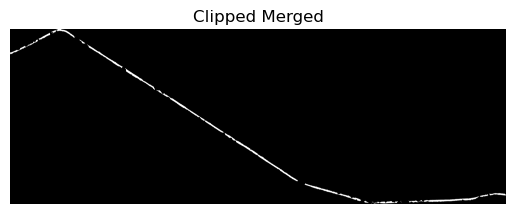

Successfully saved FMR 26-road_final-3-RGB.tif to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]\PNEO WIDTHS\FMR 26\FMR 26-road_final-3-RGB.tif
Road width exported successfully to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]\PNEO WIDTHS\FMR 26\FMR 26-widths_tol_0.15-3-RGB.geojson
Width extraction completed.
                                              geometry     width
0    LINESTRING (283414.265 1710970.720, 283412.018...  5.237351
2    LINESTRING (283432.439 1710979.072, 283430.481...  4.563727
3    LINESTRING (283441.548 1710983.202, 283439.445...  4.902794
4    LINESTRING (283450.427 1710987.817, 283448.512...  4.462799
8    LINESTRING (283486.588 1711005.166, 283484.318...  4.880964
..                                                 ...       ...
140  LINESTRING (284771.569 1710565.780, 284770.698...  4.126199
142  LINESTRING (284791.105 1710569.211

In [25]:
buffer_dist = 3
final_clipped_data, final_clipped_transform = preprocessor.clipraster(
						raster_data = thresh.astype(np.uint8),
						transform = clipped_transform,
						buffer_dist = buffer_dist)


final_clipped_data = np.squeeze(final_clipped_data)
final_clipped_data = cv2.morphologyEx(final_clipped_data.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=4)

plt.imshow(final_clipped_data, cmap="gray")
plt.axis("off")
plt.title("Clipped Merged")
plt.show()



measure = MeasureWidth(final_clipped_data, final_clipped_transform, vector_path)
tol = 0.15
measure.process(tolerance=tol)

output_folder = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]\PNEO WIDTHS"
outpath = os.path.join(output_folder, basename, basename + f"-road_final-{buffer_dist}-RGB.tif")
export(final_clipped_data, final_clipped_transform, outpath)

measure.export(os.path.join(output_folder, basename, basename + f"-widths_tol_{tol}-{buffer_dist}-RGB.geojson"))
print("Width extraction completed.")
print(measure.transects)

vectorized_road = measure.vectorized
# vectorized_road.plot()
vectorized_road.to_file(os.path.join(output_folder, basename, basename + f"-vectorized_road-tol_{tol}-{buffer_dist}.geojson"), driver="GeoJSON")

In [74]:
output_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_202501230237466\FMR20"
export(ndvi, raster.transform, os.path.join(output_path, os.path.basename(output_path) + "_NDVI.tif"), crs=raster.crs)

Successfully saved FMR20_NDVI.tif to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_202501230237466\FMR20\FMR20_NDVI.tif


In [ ]:


#Apply erode
morph_warm = Morph(warm_raster)
morph_warm.process()

morph_stretch = Morph(stretch_raster)
morph_stretch.process()

#merges the applied morphed warmth and stretch function
merged_or = np.logical_or(morph_warm.output, morph_stretch.output)

plt.imshow(merged_or, cmap="gray")
plt.axis("off")
plt.title("Merged")
plt.show()

final_clipped_data, final_clipped_transform = preprocessor.clipraster(
						raster_data = merged_or.astype(np.uint8),
						transform = clipped_transform,
						buffer_dist = 3.25)


final_clipped_data = np.squeeze(final_clipped_data)
plt.imshow(final_clipped_data, cmap="gray")
plt.axis("off")
plt.title("Clipped Merged")
plt.show()

In [ ]:
#FOR PNEO; Filters: warmth and linear stretch
filter = Filters(clipped_data)
warm_raster = filter.enhance_image_warmth()
stretch_raster = filter.enhance_linear_stretch()

warm_raster = np.moveaxis(warm_raster, 0, -1)
stretch_raster = np.moveaxis(stretch_raster, 0, -1)

plt.imshow(warm_raster)
plt.title("Warmth (PNEO)")
plt.axis('off')
plt.show()

plt.imshow(stretch_raster)
plt.title("Stretched (PNEO)")
plt.axis('off')
plt.show()

In [ ]:
#measuring widths and exports
output_folder = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]"
outpath = os.path.join(output_folder, basename, basename + "-road_final.tif")
# export(final_clipped_data,final_clipped_transform, output_path=outpath)

measure = MeasureWidth(final_clipped_data, final_clipped_transform, vector_path)

measure.process(tolerance=0.6)
# measure.export(os.path.join(dirname, basename + "-widths_tol_0.7.geojson"))
print("Width extraction completed.")
print(measure.transects)

vectorized_road = measure.vectorized
vectorized_road.plot()

(3, 7898, 7567)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


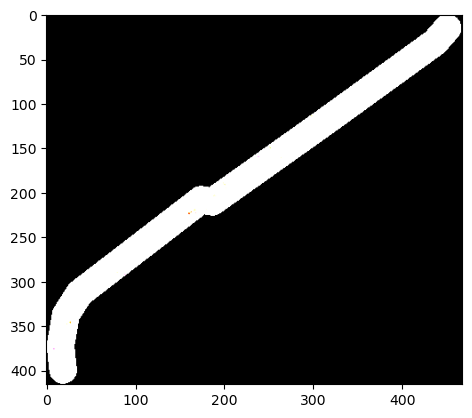

1.0 0.0


In [ ]:
#MAIN.PY PROTOTYPE
files = [(r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\NUEVA ECIJA FMR\FMR 29\BSG-114-20240714-024400-256873765_ortho.tif",
          r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\NUEVA ECIJA FMR\FMR 29\FMR 29 CL\FMR 29_CL.shp")
        #   ,
        #   (r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\NUEVA ECIJA FMR\FMR 30a\BSG-116-20240822-025950-268621368-Tiff.tif",
        #    r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\NUEVA ECIJA FMR\FMR 30a\30a.shp"),
        #     (r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\NUEVA ECIJA FMR\FMR 30b\BSG-116-20240822-025950-268621368-Tiff.tif",
        #    r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\NUEVA ECIJA FMR\FMR 30b\30b.shp")
        ]
for raster, centerline in files:    
    #preprocessing
    raster_path = raster
    vector_path = centerline

    dirname = os.path.dirname(raster_path)
    basename = os.path.basename(dirname)

    preprocessor = Preprocessing(raster_path, vector_path)
    rep_data, rep_trans, rep_crs = preprocessor.reproject()
    print(rep_data.shape)
    clipped_data, clipped_transform = preprocessor.clipraster() #bbox=False

    plt.imshow(np.moveaxis(clipped_data, 0, -1))
    plt.show()

    #Filters: warmth and linear stretch
    filter = Filters(clipped_data)
    warm_raster = filter.enhance_image_warmth()
    stretch_raster = filter.enhance_linear_stretch()

    # # Display the result
    # fig, axes = plt.subplots(1, 2, figsize=(12,10), sharex=True, sharey=True)
    # ax = axes.ravel()

    # ax[0].imshow(np.moveaxis(warm_raster, 0, -1), cmap=plt.cm.gray)
    # ax[0].set_title('Warm')
    # ax[0].axis("off")

    # ax[1].imshow(np.moveaxis(stretch_raster, 0, -1), cmap=plt.cm.gray)
    # ax[1].set_title('Stretch')
    # ax[1].axis("off")

    #Apply erode (IN MORPH: raster is normalized, converted to gray )
    morph_warm = Morph(warm_raster)
    morph_warm.process()
    # morph_warm.display()
    print(np.max(morph_warm.normalized), np.min(morph_warm.normalized))

    morph_stretch = Morph(stretch_raster)
    morph_stretch.process()
    # morph_stretch.display()

    #merges the applied morphed warmth and stretch function
    merged_or = np.logical_or(morph_warm.output, morph_stretch.output)

    # plt.imshow(merged_or, cmap="gray")
    # plt.axis("off")
    # plt.title("Merged")
    # plt.show()

    # final_clipped_data, final_clipped_transform = preprocessor.clipraster(
    #                         raster_data = merged_or.astype(np.uint8),
    #                         transform = clipped_transform,
    #                         buffer_dist = 3.25)


    # final_clipped_data = np.squeeze(final_clipped_data)
    # plt.imshow(final_clipped_data, cmap="gray")
    # plt.axis("off")
    # plt.title("Clipped Merged")
    # plt.show()

    # output_folder = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]"
    # outpath = os.path.join(output_folder, basename, basename + "-road_final.tif")
    # export(final_clipped_data,final_clipped_transform, output_path=outpath)

    # measure = MeasureWidth(final_clipped_data, final_clipped_transform, vector_path)

    # measure.process(tolerance=0.4)
    # # measure.export(os.path.join(output_folder, basename, basename + "-widths_tol_0.4.geojson"))
    # print("Width extraction completed.")
    # print(measure.transects)

    # vectorized_road = measure.vectorized
    # vectorized_road.plot()

In [17]:
print(np.mean(measure.transects['width']))
print(np.std(measure.transects['width']))

7.21954096889575
1.2550097638692643


Width extraction completed.
                                              geometry     width
0    LINESTRING (283429.388 1710988.544, 283425.307...  7.056628
1    LINESTRING (283437.282 1710993.609, 283434.070...  7.476066
2    LINESTRING (283446.385 1710997.610, 283443.283...  7.460300
3    LINESTRING (283455.387 1711002.540, 283452.166...  6.682955
4    LINESTRING (283464.279 1711007.124, 283460.830...  7.154691
..                                                 ...       ...
150  LINESTRING (284794.368 1710586.600, 284793.447...  6.861290
151  LINESTRING (284804.324 1710587.601, 284803.268...  7.868242
152  LINESTRING (284813.503 1710588.600, 284813.981...  7.809888
153  LINESTRING (284823.522 1710588.600, 284823.939...  6.812787
154  LINESTRING (284833.479 1710587.601, 284833.896...  6.811378

[133 rows x 2 columns]


<Axes: >

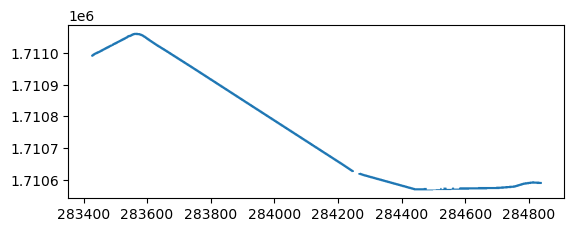

In [42]:
measure = MeasureWidth(final_clipped_data, final_clipped_transform, vector_path)
measure.process(tolerance=0.4)
# measure.export(os.path.join(output_folder, basename, basename + "-widths_tol_0.6.geojson"))
print("Width extraction completed.")
print(measure.transects)

vectorized_road = measure.vectorized
vectorized_road.plot()

In [ ]:
#FOR ON-GOING FMR (BATAAN-03)

image_1 = r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\On-going FMR\03\03\02-19-2025_raw.tif"
image_2 = r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\On-going FMR\03\03\02-28-2025_raw.tif"
vector_path = r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\On-going FMR\03\BATAAN_FMR.shp"

preprocessor = Preprocessing(image_1, vector_path)
preprocessor.reproject()
raster_data, raster_transform = preprocessor.clipraster(bbox=True)

filter = Filters(raster_data)
stretch_raster = filter.enhance_linear_stretch()
warm_raster = filter.enhance_image_warmth()

morph_warm = Morph(warm_raster)
morph_warm.process()

morph_stretch = Morph(stretch_raster)
morph_stretch.process()

#merges the applied morphed warmth and stretch function
merged_or = np.logical_or(morph_warm.output, morph_stretch.output)
final_raster_1 = merged_or

preprocessor = Preprocessing(image_2, vector_path)
preprocessor.reproject()
raster_data, raster_transform = preprocessor.clipraster(bbox=True)

filter = Filters(raster_data)
stretch_raster = filter.enhance_linear_stretch()
warm_raster = filter.enhance_image_warmth()

morph_warm = Morph(warm_raster)
morph_warm.process()

morph_stretch = Morph(stretch_raster)
morph_stretch.process()

#merges the applied morphed warmth and stretch function
merged_or = np.logical_or(morph_warm.output, morph_stretch.output)
final_raster_2 = merged_or

fig, axes = plt.subplots(1, 2, figsize=(12,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(final_raster_1, cmap='gray')
ax[0].set_title("02-19-2025")
ax[0].axis("off")

ax[1].imshow(final_raster_2, cmap='gray')
ax[1].set_title("02-28-2025")
ax[1].axis("off")

export(final_raster_1.astype(np.uint8), raster_transform, r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\On-going FMR\03\03\02-19-2025_road.tif")
export(final_raster_2.astype(np.uint8), raster_transform, r"C:\Users\user-307E4B3400\Desktop\BAFE FMR\On-going FMR\03\03\02-28-2025_road.tif")


In [10]:
image = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_05315915405614\FMR 26\FMR26-PANSHARPENED.tif"
vector_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_05315915405614\FMR 26\FMR26_PNEO_CL.shp"

dirname = os.path.dirname(image)
basename = os.path.basename(dirname)

preprocessor = Preprocessing(image, vector_path, pneo=True)
preprocessor.reproject()
raster_data, raster_transform = preprocessor.clipraster()

filter = Filters(raster_data)
stretch_raster = filter.enhance_linear_stretch()

morph = Morph(stretch_raster)
morph.normalize_raster() 
morph.threshold_raster()
final_raster = morph.thresholded

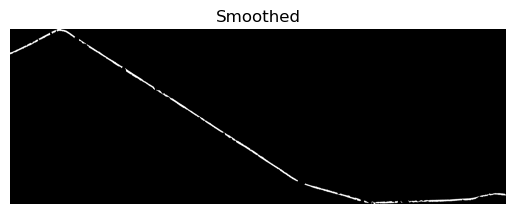

Road width exported successfully to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.test\FMR 26\FMR 26-widths-res_64-CONT.geojson
Width extraction completed.
                                              geometry     width
0    LINESTRING (283414.170 1710970.920, 283412.022...  5.005436
2    LINESTRING (283432.373 1710979.210, 283430.267...  4.910252
3    LINESTRING (283441.484 1710983.336, 283439.507...  4.609518
4    LINESTRING (283450.460 1710987.747, 283448.456...  4.670499
5    LINESTRING (283459.784 1710991.423, 283457.845...  4.519849
..                                                 ...       ...
142  LINESTRING (284742.658 1710558.576, 284741.463...  4.184076
144  LINESTRING (284761.766 1710563.781, 284760.803...  4.599790
146  LINESTRING (284781.137 1710568.269, 284780.473...  4.674806
149  LINESTRING (284810.435 1710569.048, 284811.011...  5.113110
150  LINESTRING (284820.377 1710567.970, 284820.936...  4.958411

[116 row

In [24]:
#will insert the centerline creation here then do the final clipping.

final_clipped_data, final_clipped_transform = preprocessor.clipraster(
                        raster_data = final_raster.astype(np.uint8),
                        transform = raster_transform,
                        buffer_dist = 3.0)


final_clipped_data = np.squeeze(final_clipped_data)
final_clipped_data = cv2.morphologyEx(final_clipped_data.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=4)

# Find contours
contours, _ = cv2.findContours(final_clipped_data, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Smooth contours using approximation
epsilon = 0.0007 * cv2.arcLength(contours[0], True)
smoothed_contours = [cv2.approxPolyDP(cnt, epsilon, True) for cnt in contours]

# Draw smoothed contours on a blank image
final_clipped_data = np.zeros_like(final_clipped_data)
cv2.drawContours(final_clipped_data, smoothed_contours, -1, 1, thickness=cv2.FILLED)

plt.imshow(final_clipped_data, cmap="gray")
plt.axis("off")
plt.title("Smoothed")
plt.show()

measure = MeasureWidth(final_clipped_data, final_clipped_transform, vector_path)
tol = 0.10
res = 64
measure.process(tolerance=tol, resolution=res)

output_folder = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.test"

measure.export(os.path.join(output_folder, basename, basename + f"-widths-res_{res}-CONT.geojson"))
print("Width extraction completed.")
print(measure.transects)

outpath = os.path.join(output_folder, basename, basename + f"-road_final-test-res_{res}-CONT.tif")
export(final_clipped_data, final_clipped_transform, output_path=outpath)
measure.export(os.path.join(output_folder, basename, basename + f"-vectorized_road-test-res_{res}-CONT.geojson"), gdf = measure.vectorized_roads)
print("Exporting vectorized road completed.")



C:\Users\user-307E4B3400\AppData\Local\Temp\ipykernel_7556\4126091042.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


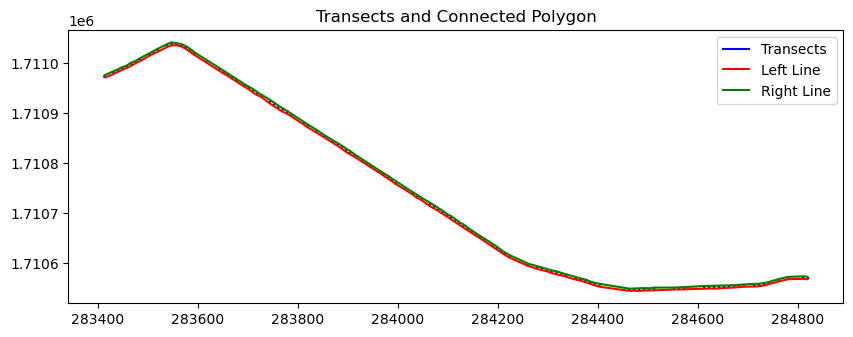

In [33]:
transects = measure.transects['geometry']

# Extract the endpoints of the transects
left_points = [transect.coords[0] for transect in transects]  # Start points
right_points = [transect.coords[1] for transect in transects]  # End points

# Create LineStrings by connecting the endpoints
left_line = shapely.geometry.LineString(left_points)  # Line along the left side
right_line = shapely.geometry.LineString(right_points)  # Line along the right side

# Create a Polygon by combining the left and right lines
polygon = shapely.geometry.Polygon(left_points + right_points[::-1])  # Reverse right points to close the polygon

# Create GeoDataFrames for visualization
gdf_transects = gpd.GeoDataFrame(geometry=transects)
gdf_left_line = gpd.GeoDataFrame(geometry=[left_line])
gdf_right_line = gpd.GeoDataFrame(geometry=[right_line])
gdf_polygon = gpd.GeoDataFrame(geometry=[polygon])

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
gdf_transects.plot(ax=ax, color='blue', label="Transects")
gdf_left_line.plot(ax=ax, color='red', label="Left Line")
gdf_right_line.plot(ax=ax, color='green', label="Right Line")
gdf_polygon.plot(ax=ax, color='yellow', alpha=0.5, label="Polygon")

plt.legend()
plt.title("Transects and Connected Polygon")
plt.show()

gdf = gpd.GeoDataFrame({
    'id': [1, 2],  # Unique IDs for each line
    'geometry': [left_line, right_line],
    'description': ['Left Line', 'Right Line']  # Optional: Add descriptions
})

gdf_polygon = gpd.GeoDataFrame({
    'id': [1],  # Unique ID for the polygon
    'geometry': [polygon],
    'description': ['Polygon']  # Optional: Add description
})

# Set the coordinate reference system (CRS)
gdf_polygon.set_crs(epsg=32651, inplace=True)  # Use WGS84 (EPSG:4326) or your desired CRS

# Export the polygon to GeoJSON
gdf_polygon.to_file(os.path.join(output_folder, basename, basename + "-transect-polygon.geojson"), driver="GeoJSON")

# Set the coordinate reference system (CRS)
# gdf.set_crs(epsg=32651, inplace=True)  # Use WGS84 (EPSG:4326) or your desired CRS

# # Export to GeoJSON
# gdf.to_file(os.path.join(output_folder, basename, basename + "-joined_lines.geojson"), driver="GeoJSON")

In [29]:
print(gdf_left_line)

                                            geometry
0  LINESTRING (283414.170 1710970.920, 283432.373...


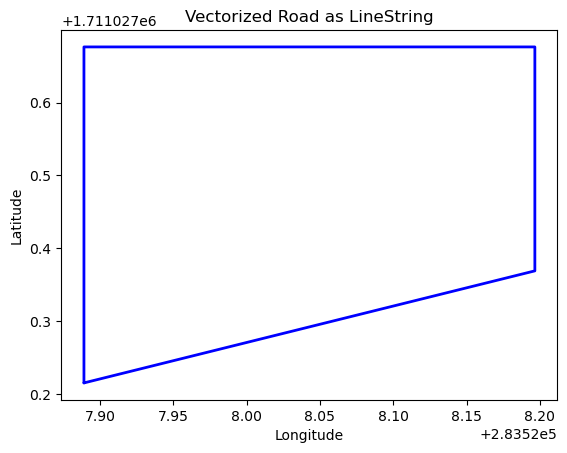

In [19]:
# Assuming measure.vectorized_roads is a GeoDataFrame with polygon geometries
vectorized_road = measure.vectorized_roads

# Convert the first polygon geometry to a Shapely Polygon object
polygon = shapely.Polygon(vectorized_road.geometry[0])

# Convert the exterior boundary to a LineString
exterior_linestring = shapely.LineString(polygon.exterior.coords)

# Convert the interior boundaries (holes) to a MultiLineString
interior_linestrings = shapely.MultiLineString([shapely.LineString(interior.coords) for interior in polygon.interiors])

# Combine exterior and interior boundaries into a single MultiLineString
combined_linestrings = shapely.MultiLineString([exterior_linestring] + [shapely.LineString(interior.coords) for interior in polygon.interiors])

# Plot the combined MultiLineString
for line in combined_linestrings.geoms:
    x, y = line.xy
    plt.plot(x, y, color='blue', linewidth=2, solid_capstyle='round', zorder=2)

plt.title("Vectorized Road as LineString")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()